In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model

%matplotlib inline

In [3]:
df = pd.read_csv('airline-passengers.csv', index_col='Month', parse_dates=['Month'])
df

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


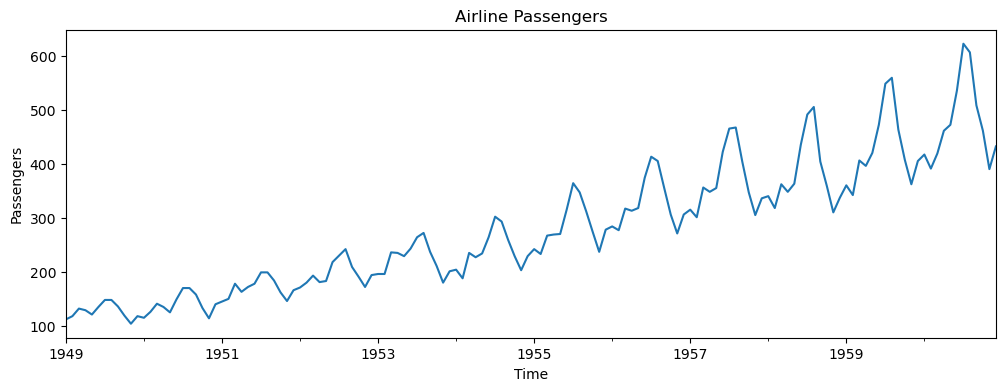

In [4]:
plt.figure(figsize=(12,4))
df['Passengers'].plot()
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.show()

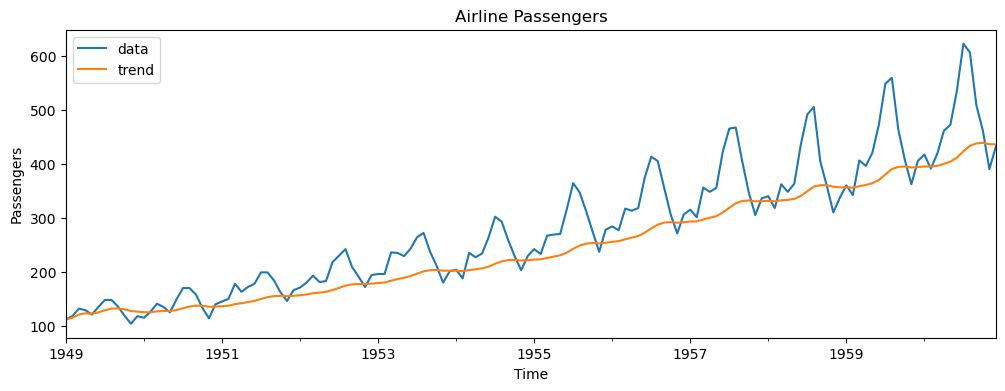

In [5]:
# df['trend'] = df['Passengers'].rolling(window=12, min_periods=1).mean()
# df['trend'] = df['Passengers'].ewm(span=12).mean()
df['trend'] = df['Passengers'].ewm(halflife=12).mean()

plt.figure(figsize=(12,4))
df['Passengers'].plot(label='data')
df['trend'].plot(label='trend')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

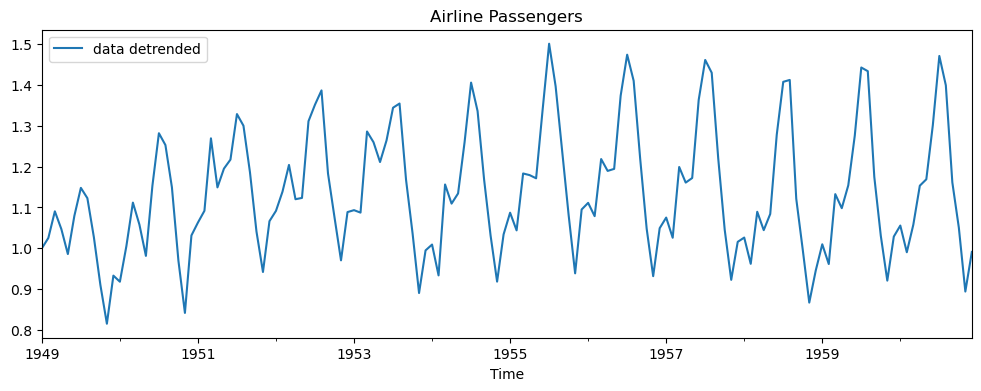

In [6]:
# df['detrended'] = df['Passengers'] - df['trend']
df['detrended'] = df['Passengers'] / df['trend']

plt.figure(figsize=(12,4))
df['detrended'].plot(label='data detrended')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

Month
1     1.045050
2     1.028700
3     1.166366
4     1.130612
5     1.131236
6     1.267675
7     1.384267
8     1.352408
9     1.167931
10    1.026496
11    0.904672
12    1.022858
Name: seasonality, dtype: float64

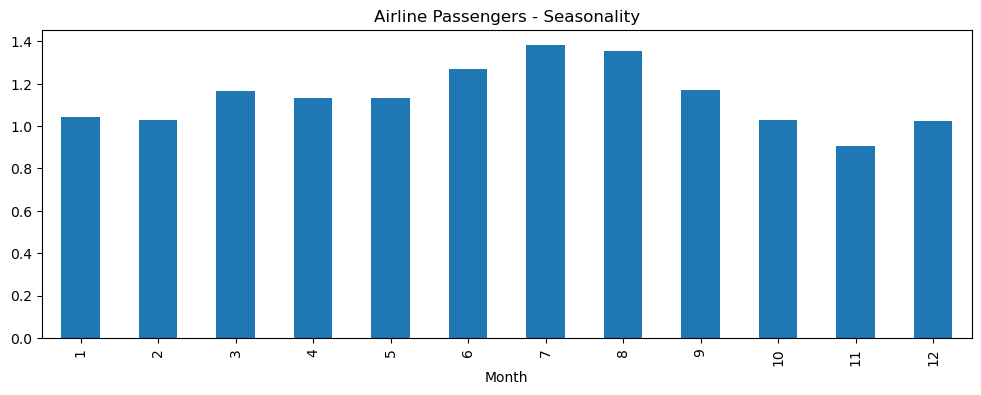

In [8]:
df_seasonality = df['detrended'].groupby(df.index.month).mean().rename('seasonality')
display(df_seasonality)

plt.figure(figsize=(12,4))
df_seasonality.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('')
plt.title('Airline Passengers - Seasonality')
plt.show()

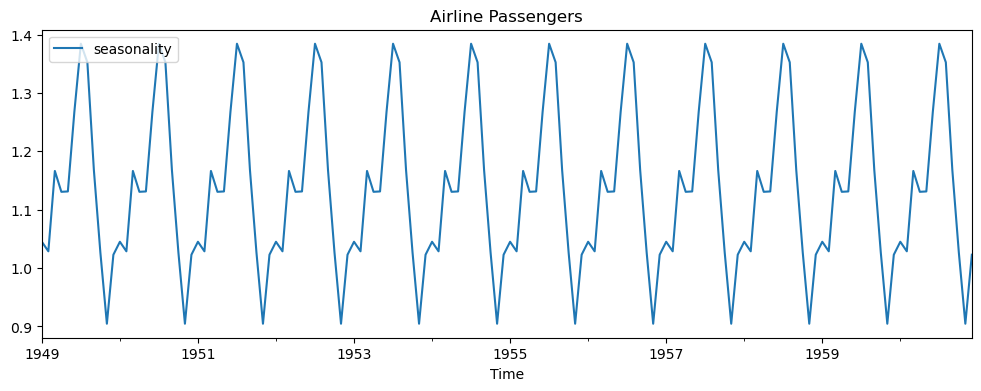

In [9]:
df = df.join(df_seasonality, how='left', on=df.index.month)

plt.figure(figsize=(12,4))
df['seasonality'].plot(label='seasonality')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

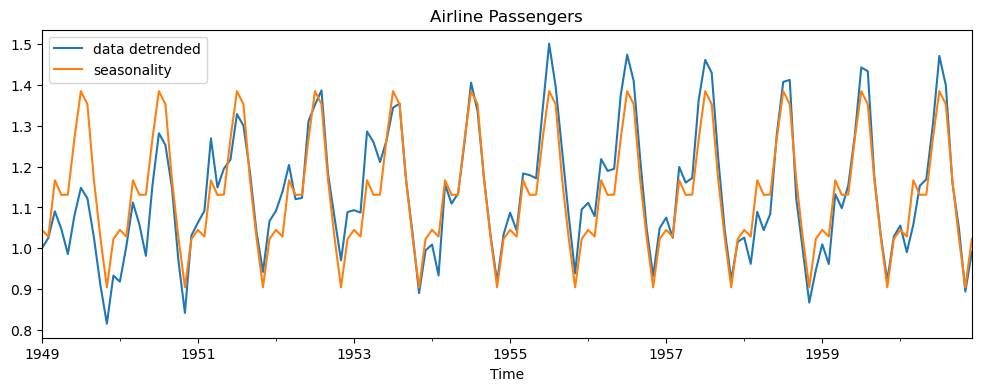

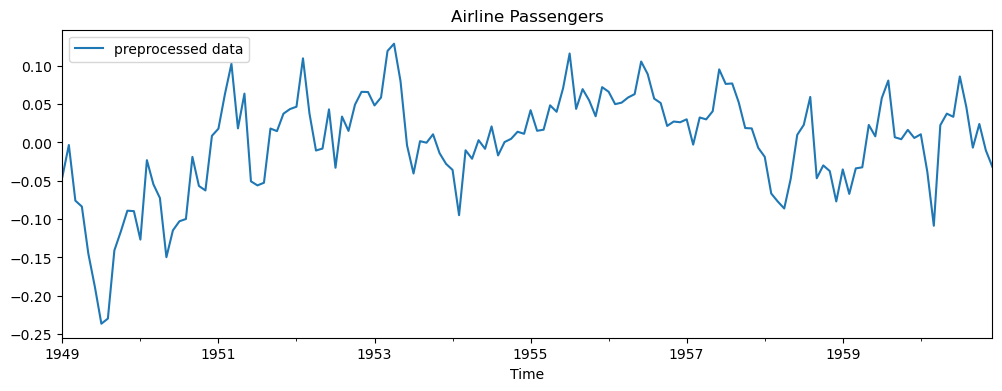

In [10]:
df['preprocessed'] = df['detrended'] - df['seasonality']

plt.figure(figsize=(12,4))
df['detrended'].plot(label='data detrended')
df['seasonality'].plot(label='seasonality')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(12,4))
df['preprocessed'].plot(label='preprocessed data')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

## Approach 1: Prediction by the global mean

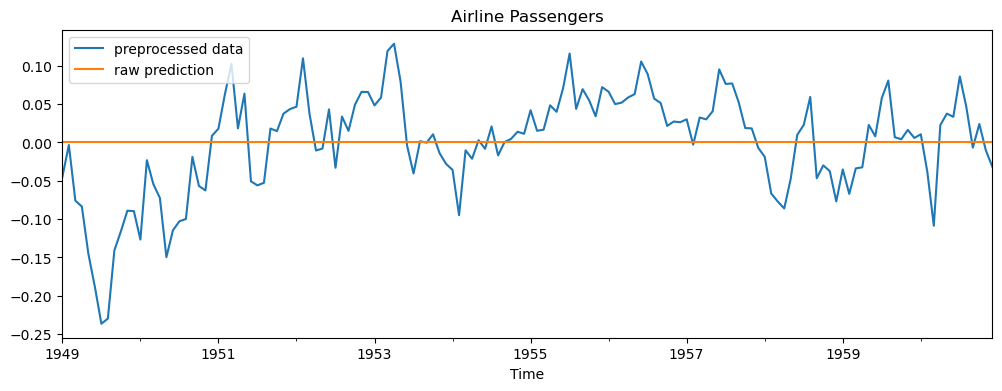

In [10]:
df['prediction_raw'] = df['preprocessed'].mean()

plt.figure(figsize=(12,4))
df['preprocessed'].plot(label='preprocessed data')
df['prediction_raw'].plot(label='raw prediction')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()


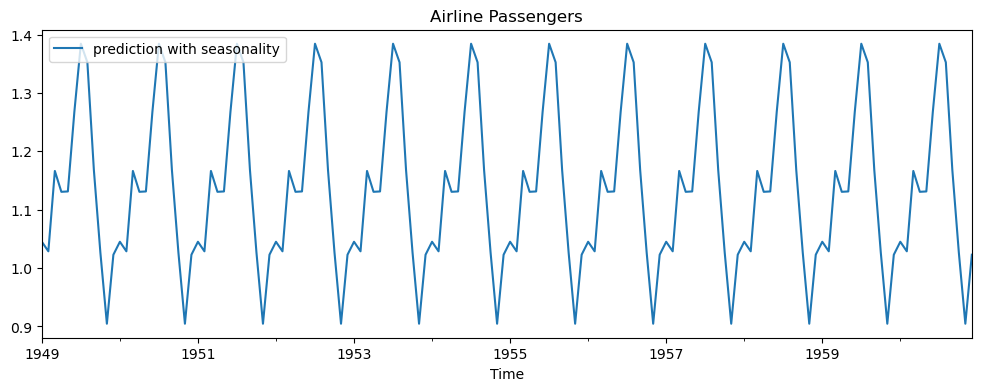

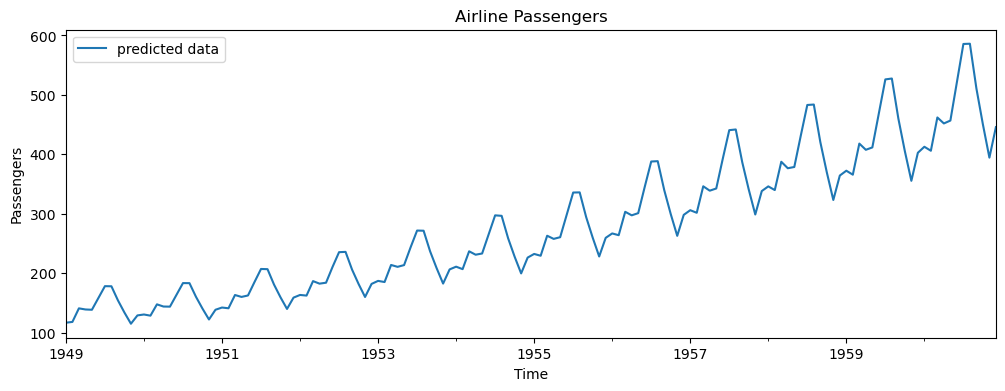

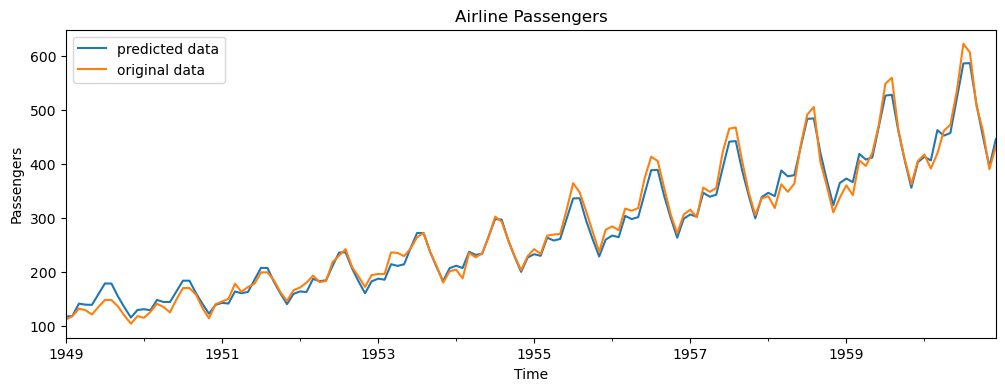

In [11]:
plt.figure(figsize=(12,4))
(df['prediction_raw'] + df['seasonality']).plot(label='prediction with seasonality')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(12,4))
((df['prediction_raw'] + df['seasonality']) * df['trend']).plot(label='predicted data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

df['prediction'] = (df['prediction_raw'] + df['seasonality']) * df['trend']

plt.figure(figsize=(12,4))
df['prediction'].plot(label='predicted data')
df['Passengers'].plot(label='original data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

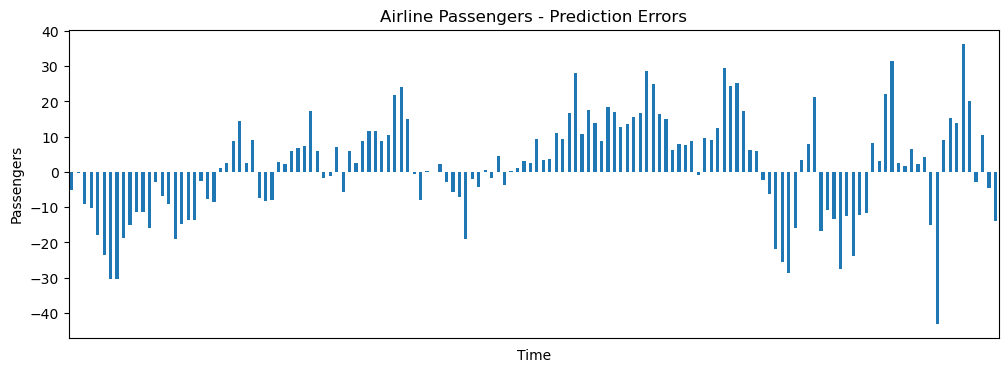

In [12]:
plt.figure(figsize=(12,4))
(df['Passengers'] - df['prediction']).plot(kind='bar')
plt.xticks([])
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers - Prediction Errors')
plt.show()

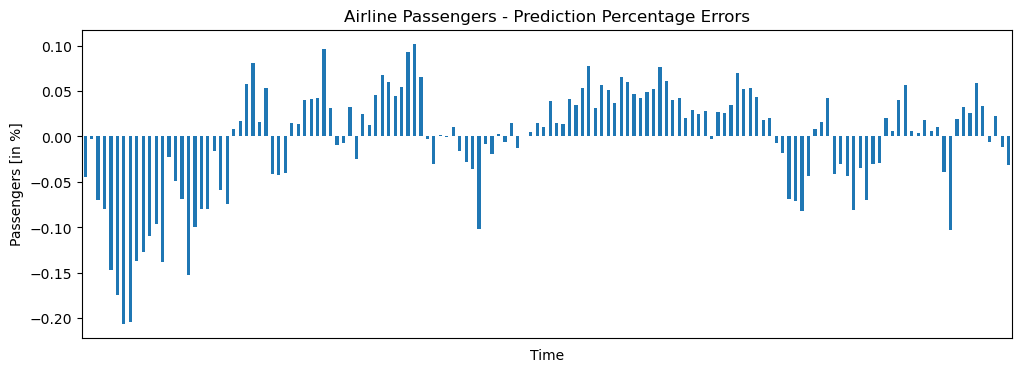

In [13]:
plt.figure(figsize=(12,4))
((df['Passengers'] - df['prediction']) / df['Passengers']).plot(kind='bar')
plt.xticks([])
plt.xlabel('Time')
plt.ylabel('Passengers [in %]')
plt.title('Airline Passengers - Prediction Percentage Errors')
plt.show()

In [14]:
print('MSE: %0.4f' % ((df['Passengers'] - df['prediction'])**2).mean())
print('MAE: %0.4f' % (df['Passengers'] - df['prediction']).abs().mean())
print('MAPE: %0.4f' % ((df['Passengers'] - df['prediction']) / df['Passengers']).abs().mean())


MSE: 199.9625
MAE: 11.2917
MAPE: 0.0454


## Approach 2: Prediction by the previous value


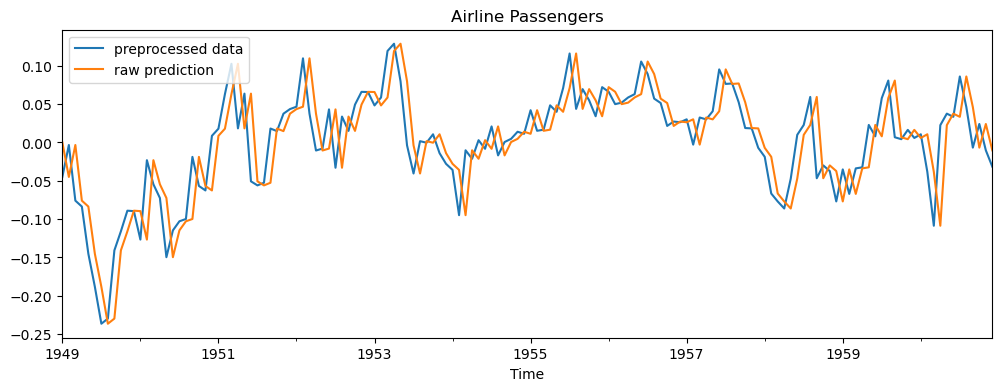

In [15]:
df['prediction_raw'] = df['preprocessed'].shift(1).fillna(0.0)

plt.figure(figsize=(12,4))
df['preprocessed'].plot(label='preprocessed data')
df['prediction_raw'].plot(label='raw prediction')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

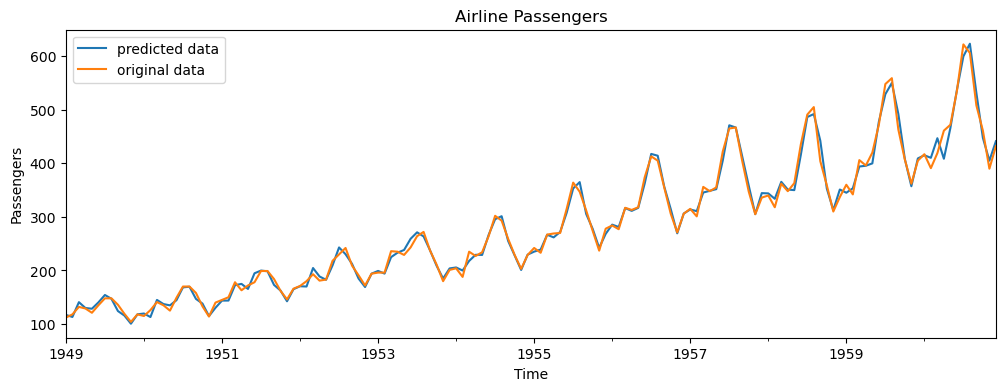

MSE: 113.5205
MAE: 7.5205
MAPE: 0.0279


In [16]:
df['prediction'] = (df['prediction_raw'] + df['seasonality']) * df['trend']

plt.figure(figsize=(12,4))
df['prediction'].plot(label='predicted data')
df['Passengers'].plot(label='original data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

print('MSE: %0.4f' % ((df['Passengers'] - df['prediction'])**2).mean())
print('MAE: %0.4f' % (df['Passengers'] - df['prediction']).abs().mean())
print('MAPE: %0.4f' % ((df['Passengers'] - df['prediction']) / df['Passengers']).abs().mean())

## Approach 3: Prediction by the moving average


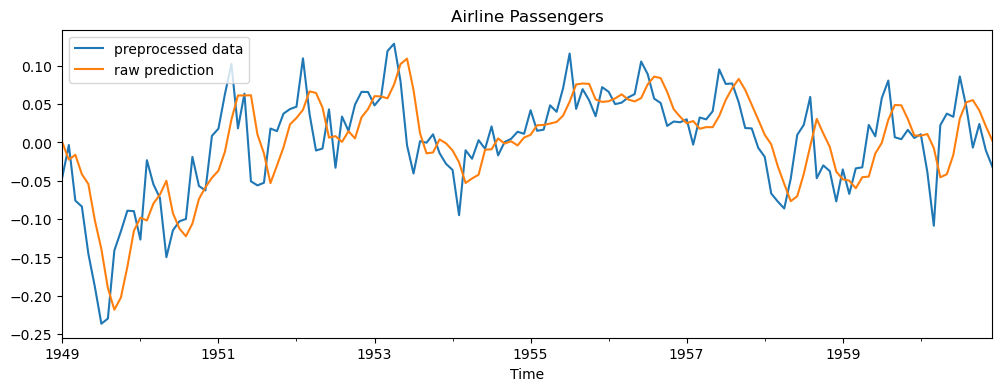

In [17]:
df['prediction_raw'] = df['preprocessed'].shift(1).fillna(0.0).rolling(window=3, min_periods=1).mean()
# df['prediction_raw'] = df['preprocessed'].shift(1).fillna(0.0).rolling(window=12, min_periods=1).mean()

plt.figure(figsize=(12,4))
df['preprocessed'].plot(label='preprocessed data')
df['prediction_raw'].plot(label='raw prediction')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

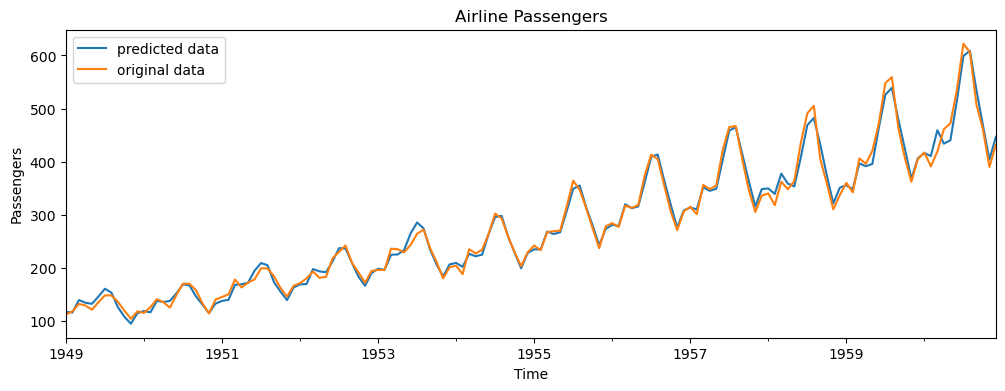

MSE: 133.8462
MAE: 8.9120
MAPE: 0.0335


In [18]:
df['prediction'] = (df['prediction_raw'] + df['seasonality']) * df['trend']

plt.figure(figsize=(12,4))
df['prediction'].plot(label='predicted data')
df['Passengers'].plot(label='original data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

print('MSE: %0.4f' % ((df['Passengers'] - df['prediction'])**2).mean())
print('MAE: %0.4f' % (df['Passengers'] - df['prediction']).abs().mean())
print('MAPE: %0.4f' % ((df['Passengers'] - df['prediction']) / df['Passengers']).abs().mean())

## Approach 4: Prediction by the linear regression

In [16]:
training_size=int(len(df)*0.65)
test_size=len(df)-training_size
train_data,test_data=df[:training_size],df[training_size:len(df)]


In [24]:
X_train,X_test = train_data['preprocessed'].shift(1).values[1:].reshape(-1, 1), test_data['preprocessed'].shift(1).values[1:].reshape(-1, 1)
y_train,y_test = train_data['preprocessed'].values[1:],test_data['preprocessed'].values[1:]

In [25]:
print("X_train:{},y_train:{},X_test:{},y_test{}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))


X_train:(92, 1),y_train:(92,),X_test:(50, 1),y_test(50,)


In [43]:
reg = linear_model.LinearRegression()

# X = df['preprocessed'].shift(1).values[1:].reshape(-1, 1)
# y = df['preprocessed'].values[1:]

reg.fit(X_train, y_train)

y_predicted = np.zeros(len(X_test)+1)
y_predicted[1:] = reg.predict(X_test)

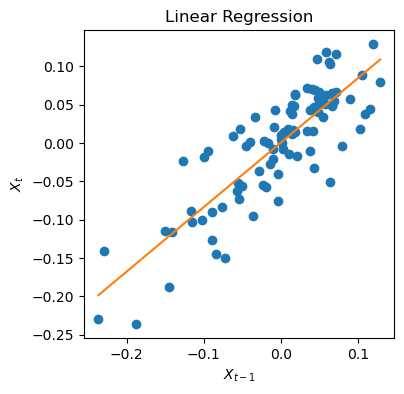

In [35]:
plt.figure(figsize=(4,4))
plt.plot(X_train[:, 0], y_train, 'o')
plt.plot([X_train.min(), X_train.max()], [reg.coef_[0] * X_train.min() + reg.intercept_, reg.coef_[0] * X_train.max() + reg.intercept_], '-')
plt.xlabel('$X_{t-1}$')
plt.ylabel('$X_t$')
plt.title('Linear Regression')
plt.show()

/var/folders/zf/z_5ht60d3n7gfsmz14cjq6fc0000gn/T/ipykernel_4220/510599637.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction_raw'] = y_predicted


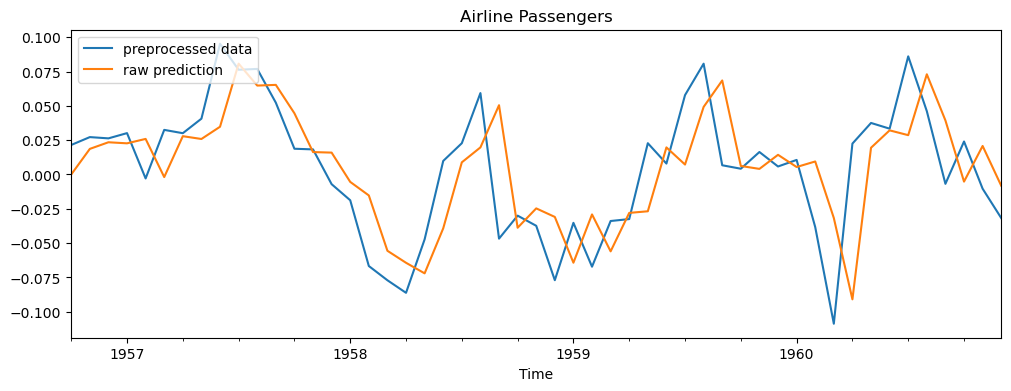

In [38]:
test_data['prediction_raw'] = y_predicted

plt.figure(figsize=(12,4))
test_data['preprocessed'].plot(label='preprocessed data')
test_data['prediction_raw'].plot(label='raw prediction')
plt.xlabel('Time')
plt.ylabel('')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

/var/folders/zf/z_5ht60d3n7gfsmz14cjq6fc0000gn/T/ipykernel_4220/3562623198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = (test_data['prediction_raw'] + test_data['seasonality']) * test_data['trend']


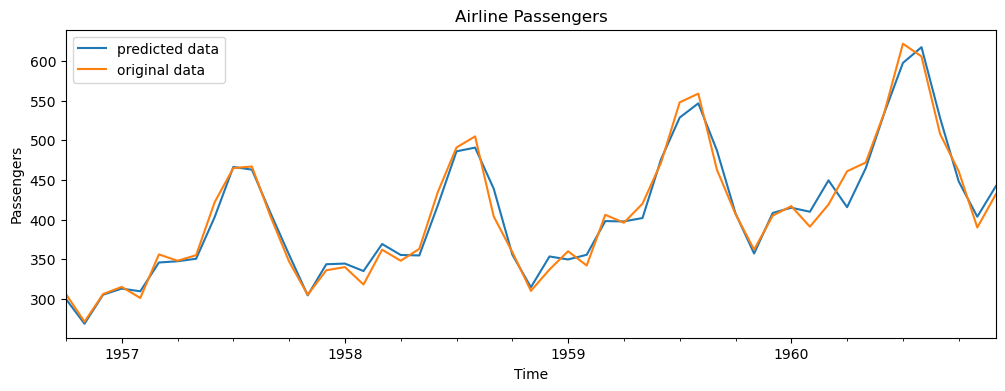

MSE: 198.2603
MAE: 10.5440
MAPE: 0.0254


In [40]:
test_data['prediction'] = (test_data['prediction_raw'] + test_data['seasonality']) * test_data['trend']

plt.figure(figsize=(12,4))
test_data['prediction'].plot(label='predicted data')
test_data['Passengers'].plot(label='original data')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Airline Passengers')
plt.legend(loc='upper left')
plt.show()

print('MSE: %0.4f' % ((test_data['Passengers'] - test_data['prediction'])**2).mean())
print('MAE: %0.4f' % (test_data['Passengers'] - test_data['prediction']).abs().mean())
print('MAPE: %0.4f' % ((test_data['Passengers'] - test_data['prediction']) / test_data['Passengers']).abs().mean())

## Approach 4a: Prediction by the multidimensional linear regression

In [23]:
def make_prediction_with_linear_regression(df, y_predicted):
    df['prediction_raw'] = y_predicted

    plt.figure(figsize=(12,4))
    df['preprocessed'].plot(label='preprocessed data')
    df['prediction_raw'].plot(label='raw prediction')
    plt.xlabel('Time')
    plt.ylabel('')
    plt.title('Airline Passengers')
    plt.legend(loc='upper left')
    plt.show()

    df['prediction'] = (df['prediction_raw'] + df['seasonality']) * df['trend']

    plt.figure(figsize=(12,4))
    df['prediction'].plot(label='predicted data')
    df['Passengers'].plot(label='original data')
    plt.xlabel('Time')
    plt.ylabel('Passengers')
    plt.title('Airline Passengers')
    plt.legend(loc='upper left')
    plt.show()

    print('MSE: %0.4f' % ((df['Passengers'] - df['prediction'])**2).mean())
    print('MAE: %0.4f' % (df['Passengers'] - df['prediction']).abs().mean())
    print('MAPE: %0.4f' % ((df['Passengers'] - df['prediction']) / df['Passengers']).abs().mean())

#### 6.1. Prediction by the linear regression on the two previous values

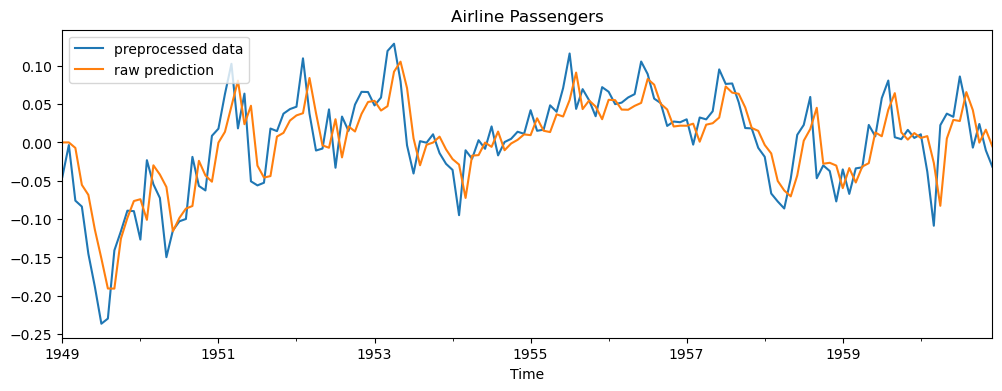

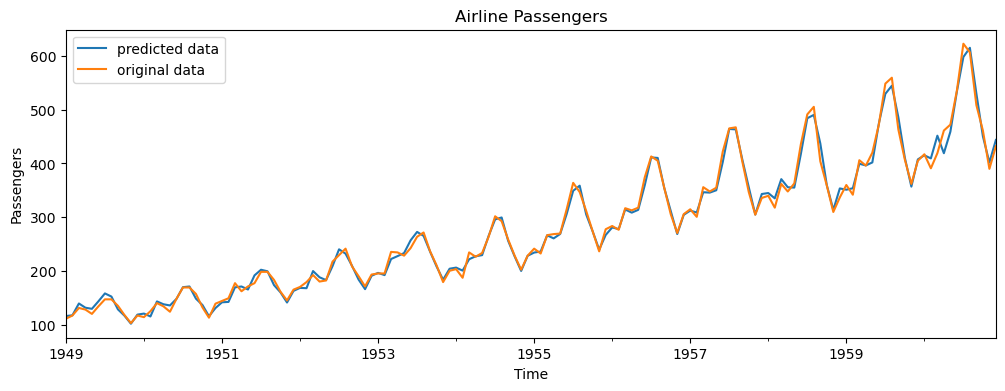

MSE: 97.8164
MAE: 7.1932
MAPE: 0.0270


In [24]:
reg = linear_model.LinearRegression()

X = np.vstack([
    df['preprocessed'].shift(1).values[2:],
    df['preprocessed'].shift(2).values[2:]
]).T
y = df['preprocessed'].values[2:]

reg.fit(X, y)

y_predicted = np.zeros(len(df))
y_predicted[2:] = reg.predict(X)

make_prediction_with_linear_regression(df, y_predicted)

#### 6.2. Prediction by the linear regression on the three previous values¶


In [33]:
df['preprocessed']
# df['preprocessed'].shift(1)

Month
1949-01-01         NaN
1949-02-01   -0.045050
1949-03-01   -0.003385
1949-04-01   -0.075935
1949-05-01   -0.083662
                ...   
1960-08-01    0.086041
1960-09-01    0.046120
1960-10-01   -0.006803
1960-11-01    0.024037
1960-12-01   -0.010348
Name: preprocessed, Length: 144, dtype: float64

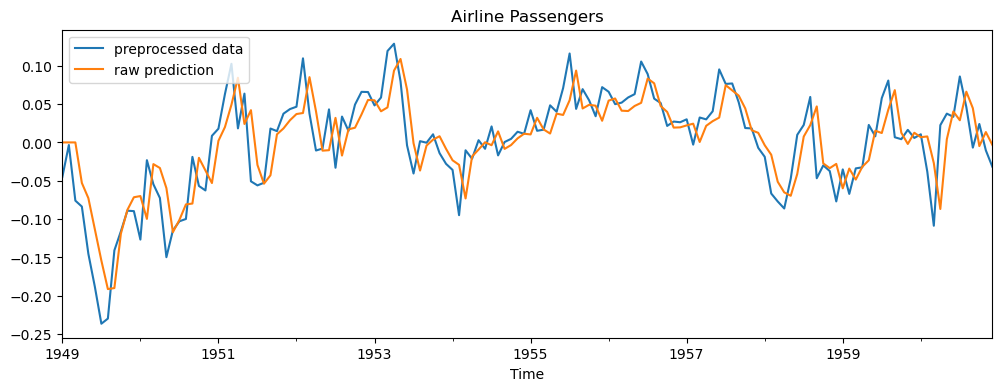

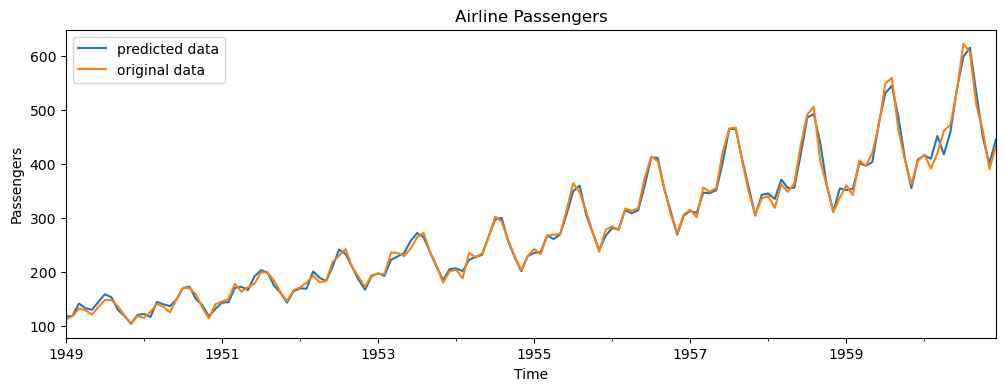

MSE: 98.3049
MAE: 7.1479
MAPE: 0.0268


In [25]:
reg = linear_model.LinearRegression()

X = np.vstack([
    df['preprocessed'].shift(1).values[3:],
    df['preprocessed'].shift(2).values[3:],
    df['preprocessed'].shift(3).values[3:]
]).T
y = df['preprocessed'].values[3:]

reg.fit(X, y)

y_predicted = np.zeros(len(df))
y_predicted[3:] = reg.predict(X)

make_prediction_with_linear_regression(df, y_predicted)


#### 6.3. Autocorrelation¶


In [26]:
np.corrcoef(df['preprocessed'][1:], df['preprocessed'].shift(1)[1:])

array([[1.        , 0.80477507],
       [0.80477507, 1.        ]])

In [27]:
np.corrcoef(df['preprocessed'][2:], df['preprocessed'].shift(2)[2:])

array([[1.        , 0.68492405],
       [0.68492405, 1.        ]])

In [28]:
np.corrcoef(df['preprocessed'][3:], df['preprocessed'].shift(3)[3:])

array([[1.        , 0.55053101],
       [0.55053101, 1.        ]])

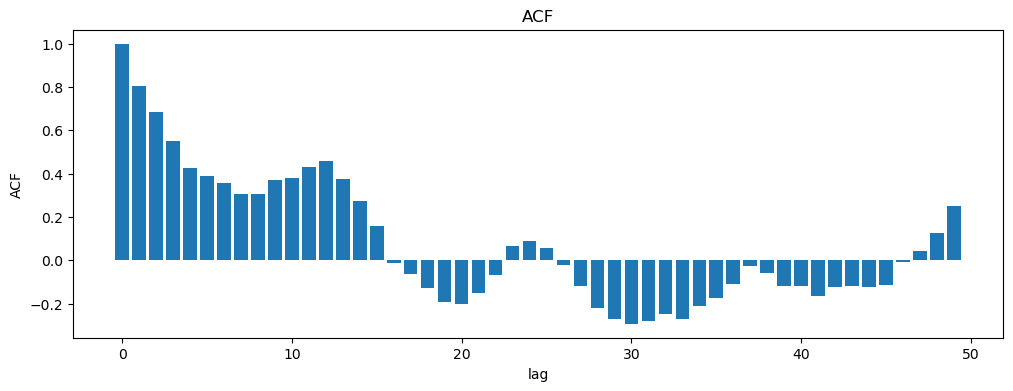

In [29]:
acf = np.zeros(50)
for lag in range(len(acf)):
    acf[lag] = np.corrcoef(df['preprocessed'][lag:], df['preprocessed'].shift(lag)[lag:])[0, 1]

plt.figure(figsize=(12,4))
plt.bar(range(len(acf)), acf)
plt.xlabel('lag')
plt.ylabel('ACF')
plt.title('ACF')
plt.show()

#### 6.4. Prediction by the linear regression on the 15 previous values¶

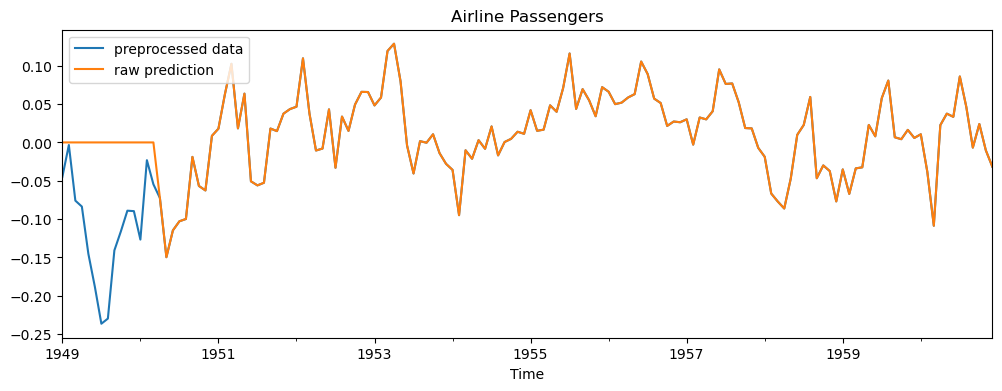

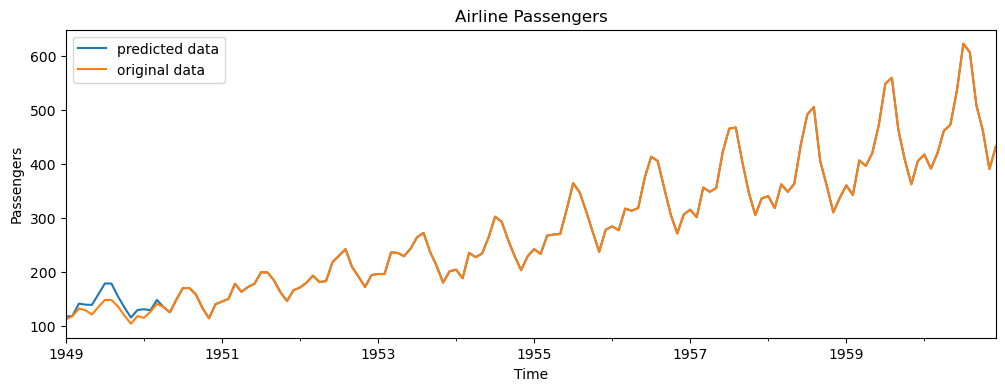

MSE: 28.3243
MAE: 1.4533
MAPE: 0.0112


In [30]:
reg = linear_model.LinearRegression()

X = np.vstack([df['preprocessed'].shift(lag).values[15:] for lag in range(15)]).T
y = df['preprocessed'].values[15:]

reg.fit(X, y)

y_predicted = np.zeros(len(df))
y_predicted[15:] = reg.predict(X)

make_prediction_with_linear_regression(df, y_predicted)